## Required Library

In [1]:
import cv2 
import tifffile 
import numpy as np
import math
import pandas as pd

import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0" # specify visible gpu(s) 0-3
import tensorflow as tf
try:
    tf_gpus = tf.config.list_physical_devices('GPU')
    for gpu in tf_gpus:
        tf.config.experimental.set_memory_growth(gpu, True) # allow memory growth on visible gpu(s)
except:
    pass 

import skimage.io as io
from skimage import img_as_ubyte
from datetime import datetime
from matplotlib import pyplot as plt
date = datetime.today().strftime('%Y-%m-%d')

from deepcell.applications import Mesmer
from deepcell.utils.plot_utils import create_rgb_image, make_outline_overlay


## Fusion scan

### Load Fusion scan

In [2]:
fusion_scan = tifffile.imread('../FINAL-TONSIL_2nd_L24_Scan1.qptiff')


### Rotate Fusion scan

Rotate Fusion scan 180 degrees clockwise to match the orientation of GeoMx scan.

In [3]:
rotate_list = []

for i in range(fusion_scan.shape[0]):
    print(f'Rotating the {i}th channel')
    channel_rotate = cv2.rotate(fusion_scan[i], cv2.ROTATE_180)
    rotate_list.append(channel_rotate)

fusion_rotate = np.stack(rotate_list)


Rotating the 0th channel
Rotating the 1th channel
Rotating the 2th channel
Rotating the 3th channel
Rotating the 4th channel
Rotating the 5th channel
Rotating the 6th channel
Rotating the 7th channel
Rotating the 8th channel
Rotating the 9th channel
Rotating the 10th channel
Rotating the 11th channel
Rotating the 12th channel


## Segmentation

### Get nuclear and membrane channel

In [ ]:
txt_file = open('../MarkerList_L24.txt', 'r')

MarkerList = txt_file.read().split('\n')

txt_file.close()

print(MarkerList)

In [ ]:

nuclear = fusion_rotate[MarkerList.index('DAPI')]

membrane = np.sum(np.sum([fusion_rotate[MarkerList.index('CD11b')] ,fusion_rotate[MarkerList.index('CD68')],
                          fusion_rotate[MarkerList.index('CD20')] , fusion_rotate[MarkerList.index('CD163')], 
                          fusion_rotate[MarkerList.index('CD31')] , fusion_rotate[MarkerList.index('CD3')]], axis = 0))

print(f'Nuclear channel bit depth: {nuclear.dtype}')
print(f'Membrane channel bit depth: {membrane.dtype}')

fig = plt.figure(figsize = (30,30))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(nuclear, cmap = 'gray')
ax1.title.set_text('nuclear')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(membrane, cmap = 'gray')
ax2.title.set_text('membrane')
plt.show()


In [ ]:

seg_stack = np.stack((nuclear, membrane), axis = -1)
seg_stack = np.expand_dims(seg_stack, 0)

print(seg_stack.shape)


### Segment on sub region to test hyperparameter

In [62]:
crop_region = seg_stack[:, 12500:13000, 20000:20500, :]

In [83]:
mesmer = Mesmer()
predictions = mesmer.predict(crop_region, image_mpp = 0.5,
                                postprocess_kwargs_whole_cell={"maxima_threshold" : 0.1,
                                                             "interior_threshold" : 0.2},
compartment = 'nuclear')

rgb_image = create_rgb_image(crop_region, channel_colors = ["green", "blue"])
overlay = make_outline_overlay(rgb_data = rgb_image, predictions = predictions)

/opt/miniconda3/envs/cellSeg/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0. Please use `footprint` instead.
  markers = h_maxima(image=maxima,


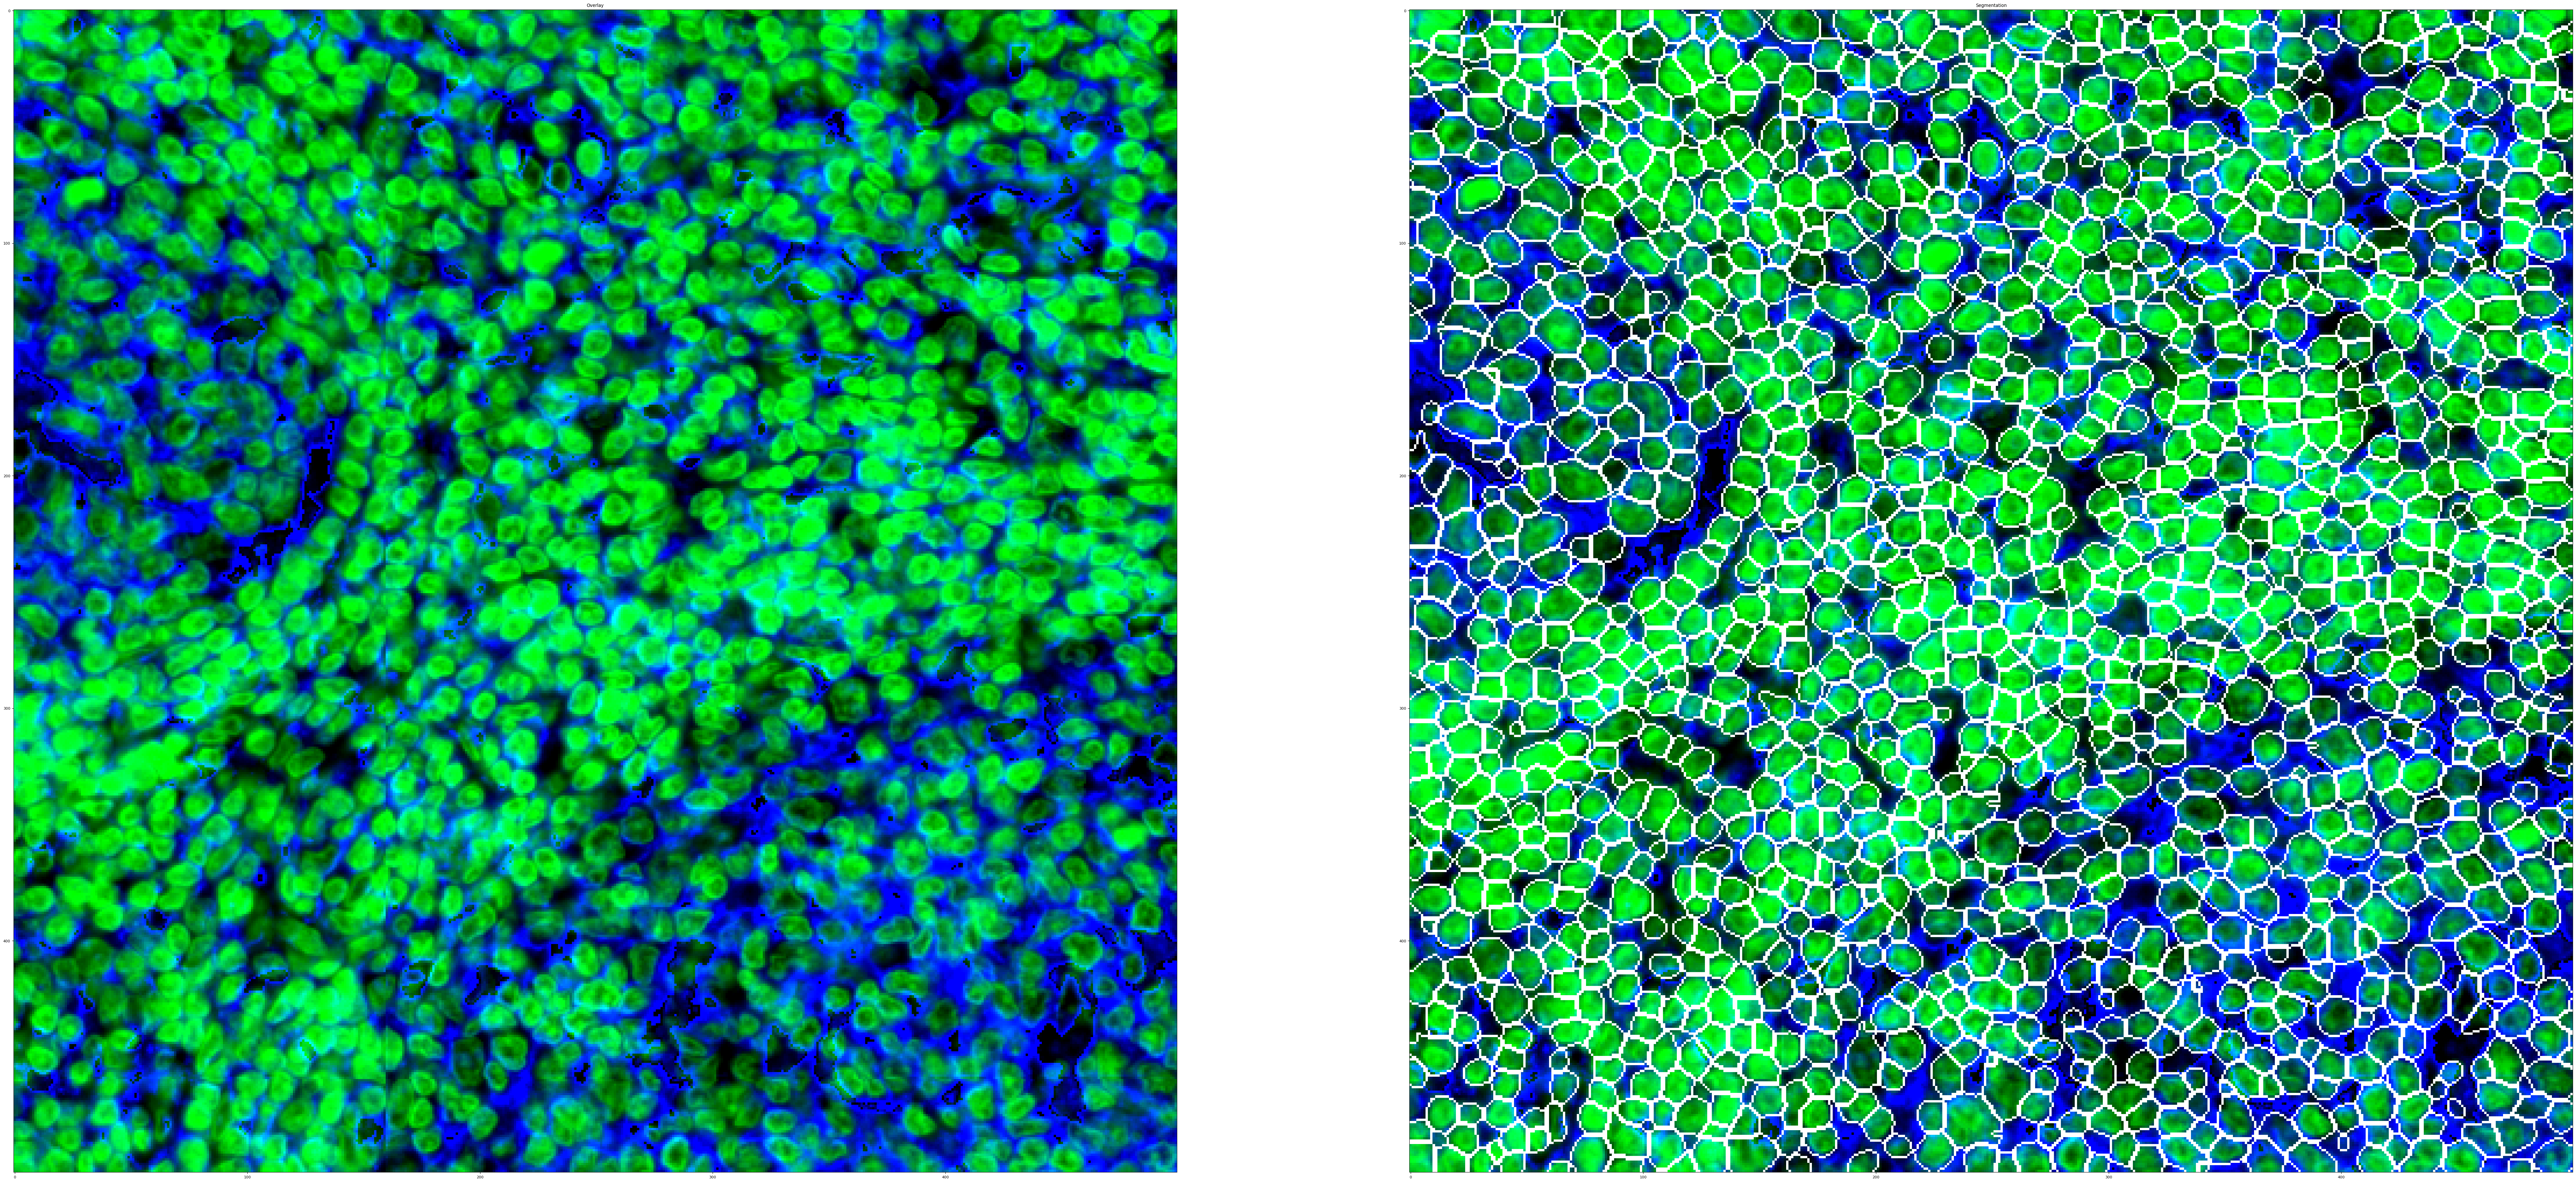

In [84]:

fig = plt.figure(figsize = (100,100))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(rgb_image[0, ...], cmap = 'gray')
ax1.title.set_text('Overlay')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(overlay[0, ...], cmap = 'gray')
ax2.title.set_text('Segmentation')
plt.show()

### Segmentation

In [ ]:
mesmer = Mesmer()
predictions = mesmer.predict(seg_stack, image_mpp = 0.5,
                                postprocess_kwargs_whole_cell={"maxima_threshold" : 0.075,
                                                             "interior_threshold" : 0.2},
                                                             compartment = 'both')

In [ ]:
rgb_image = create_rgb_image(seg_stack, channel_colors = ["green", "blue"])
overlay = make_outline_overlay(rgb_data = rgb_image, predictions = predictions)



In [ ]:

tifffile.imwrite("../seg_result/L24_seg_overlay.tiff", overlay[0, ...]) # segmentation overlay (nuc + membrane + outline)
tifffile.imwrite("../seg_result/L24_MESMER_mask.tiff", predictions[0, ..., 0]) # MESMER mask


## Extract single cell information from Fusion scan

### Read marker list

In [5]:
txt_file = open('../MarkerList_L24.txt', 'r')

clusterChannels = txt_file.read().split('\n')

txt_file.close()

print(clusterChannels)

['DAPI', 'CD11b', 'CD68', 'CD11c', 'Pax5', 'CD20', 'BCL6', 'CD8', 'CD163', 'CD4', 'FoxP3', 'CD31', 'CD3']


### Single tissue

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage 
import skimage.io
import skimage.measure
import skimage.morphology
from scipy.io import loadmat
import os

array_list=[]
ROI_img = fusion_rotate
channelNum = ROI_img.shape[0]
for i in range(channelNum):
    channelName = clusterChannels[i]
    t = ROI_img[i,...]
    array_list.append(t)

countsNoNoise=np.stack(array_list, axis=2) # count matrices in the image

# load mask
segMat = skimage.io.imread("../seg_result/L24_MESMER_mask.tiff")
stats = skimage.measure.regionprops(segMat)
labelNum = len(stats) # number of actual cells not always equal to np.max(segMat)

# init empty containers
data = np.zeros((labelNum,channelNum))
dataScaleSize = np.zeros((labelNum,channelNum))
cellSizes = np.zeros((labelNum,1))
cell_props = np.zeros((labelNum, 3))

# extract info
for i in range(labelNum): # for each cell (label)
    cellLabel = stats[i].label
    label_counts=[countsNoNoise[coord[0],coord[1],:] for coord in stats[i].coords] # all channel count for this cell
    data[i, 0:channelNum] = np.sum(label_counts, axis=0) #  sum the counts for this cell
    dataScaleSize[i,0:channelNum] = np.sum(label_counts, axis=0) / stats[i].area # scaled by size
    cellSizes[i] = stats[i].area # cell sizes
    cell_props[i, 0] = cellLabel
    cell_props[i, 1] = stats[i].centroid[0] # Y_cent
    cell_props[i, 2] = stats[i].centroid[1] # X_cent

data_df = pd.DataFrame(data)
data_df.columns = clusterChannels
data_full = pd.concat((pd.DataFrame(cell_props, columns = ["cellLabel", "Y_cent", "X_cent"]), pd.DataFrame(cellSizes, columns = ["cellSize"]), data_df), axis=1)

dataScaleSize_df = pd.DataFrame(dataScaleSize)
dataScaleSize_df.columns = clusterChannels
dataScaleSize_full = pd.concat((pd.DataFrame(cell_props, columns = ["cellLabel", "Y_cent", "X_cent"]), pd.DataFrame(cellSizes, columns = ["cellSize"]), dataScaleSize_df), axis = 1)

# save all dfs
save_dir = '../extracted_info_8_bit'

if os.path.exists(save_dir) == False:
    os.makedirs(save_dir)

data_full.to_csv(save_dir + "/L24_data_no_gate.csv", index = False)
dataScaleSize_full.to_csv(save_dir + "/L24_dataScaleSize_no_gate.csv", index = False)

## Prepare image for mantis-viewer

The tissue is too large to be viewed entirely in mantis. We need to split it into tiles

### Calculate how many tiles we need

In [126]:
TIESSUE_HEIGHT = fusion_rotate.shape[1]
TISSUE_WIDTH = fusion_rotate.shape[2]

TILE_SIZE = 2000

N_TILE_X = math.ceil(TISSUE_WIDTH/TILE_SIZE)
N_TILE_Y = math.ceil(TIESSUE_HEIGHT/TILE_SIZE)

In [127]:
counter = 0

seg_mask = tifffile.imread('../seg_result/L24_MESMER_mask.tiff')

for i in range(N_TILE_X):
    x_start = i * 2000
    x_end = (i+1) * 2000
    for j in range(N_TILE_Y):
        counter += 1
        y_start = j * 2000
        y_end = (j+1) * 2000

        print(f"tile {counter}. x_start: {x_start}, x_end: {x_end}, y_start: {y_start}, y_end: {y_end}")

    
        
        if os.path.exists(os.path.join('../mantis_img/L24', str(counter))) == False:
            os.makedirs(os.path.join('../mantis_img/L24', str(counter)))
        print(f"Writing segmentation mask for tile {counter}")
        tifffile.imwrite(f"../mantis_img/L24/{counter}/seg_mask.tiff", seg_mask[y_start:y_end, x_start:x_end])
        # Write filtered cell into a csv
        unique_cellLabel = np.unique(seg_mask[y_start:y_end, x_start:x_end])
        cellLabel_df = pd.DataFrame([counter] * len(unique_cellLabel), columns = ['tile_num'], index = None)
        cellLabel_df['cellLabel'] = unique_cellLabel
        cellLabel_df.to_csv(f'../mantis_img/L24/{counter}/{counter}.csv', index = False)

        for k in range(fusion_rotate.shape[0]):
            channel_name = clusterChannels[k]
            print(f"Writing {channel_name} for tile {counter}")
            tifffile.imwrite(os.path.join('../mantis_img/L24', str(counter), channel_name + '.tiff'), fusion_rotate[k, y_start:y_end, x_start:x_end])

tile 1. x_start: 0, x_end: 2000, y_start: 0, y_end: 2000
Writing segmentation mask for tile 1
Writing DAPI for tile 1
Writing CD11b for tile 1
Writing CD68 for tile 1
Writing CD11c for tile 1
Writing Pax5 for tile 1
Writing CD20 for tile 1
Writing BCL6 for tile 1
Writing CD8 for tile 1
Writing CD163 for tile 1
Writing CD4 for tile 1
Writing FoxP3 for tile 1
Writing CD31 for tile 1
Writing CD3 for tile 1
tile 2. x_start: 0, x_end: 2000, y_start: 2000, y_end: 4000
Writing segmentation mask for tile 2
Writing DAPI for tile 2
Writing CD11b for tile 2
Writing CD68 for tile 2
Writing CD11c for tile 2
Writing Pax5 for tile 2
Writing CD20 for tile 2
Writing BCL6 for tile 2
Writing CD8 for tile 2
Writing CD163 for tile 2
Writing CD4 for tile 2
Writing FoxP3 for tile 2
Writing CD31 for tile 2
Writing CD3 for tile 2
tile 3. x_start: 0, x_end: 2000, y_start: 4000, y_end: 6000
Writing segmentation mask for tile 3
Writing DAPI for tile 3
Writing CD11b for tile 3
Writing CD68 for tile 3
Writing CD11c